In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
tf.__version__

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split


In [ ]:
df1=pd.read_csv('/content/sample_data/fake_job_postings_og.csv')

In [ ]:
df1.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
col_desc = pd.DataFrame()
col_desc["column"] = df1.columns
col_desc["description"] = [
    "A unique ID assigned to each job",
    "The title of the advertised position or job",
    "Information about where is the job",
    "The department offering the job",
    "The amount that the job pays",
    "Information about the company advertising the job",
    "Job description",
    "Requirements enlisted",
    "Benefits offered by the company with the job",
    "1 if work from home allowed, 0 otherwise",
    "1 if the company has a logo, 0 otherwise",
    "1 if the job has any questions, 0 otherwise",
    "full-time, part-time, or contract etc.",
    "the experience required for the job",
    "educational requirements for the job",
    "The industry the job is in e.g engineering",
    "what work is required from the applicant",
    "1 if fake job, 0 if real job"
]
col_desc

,column,description
0,job_id,A unique ID assigned to each job
1,title,The title of the advertised position or job
2,location,Information about where is the job
3,department,The department offering the job
4,salary_range,The amount that the job pays
5,company_profile,Information about the company advertising the job
6,description,Job description
7,requirements,Requirements enlisted
8,benefits,Benefits offered by the company with the job
9,telecommuting,"1 if work from home allowed, 0 otherwise"


**Exploratory Data Analysis**

1. Visualizing number of Nan values in each column

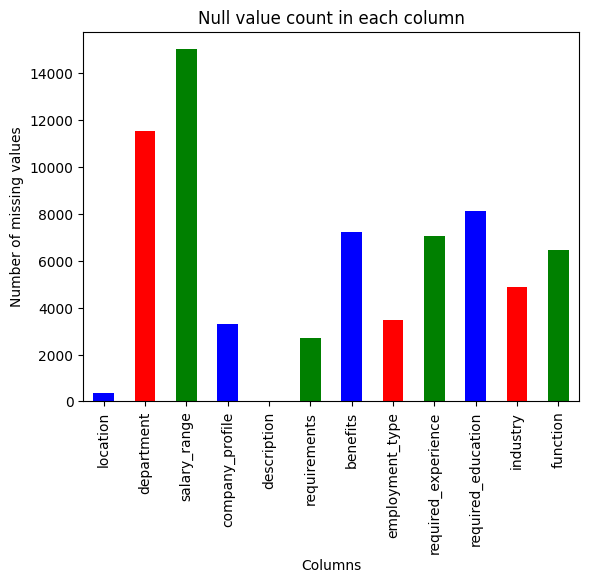

In [ ]:
missing = df1.isna().sum()
missing = missing[missing!=0]

ax = missing.plot(kind='bar', color=["b", "r", "g"])
ax.set_ylabel("Number of missing values")
ax.set_xlabel("Columns")
_ = plt.title("Null value count in each column")

Removing deparment and salary_range due to very high number of Nan values

In [ ]:
df1 = df1.drop(['department', 'salary_range'], axis=1)
df1.head(3)

,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


**Correlation heatmap**

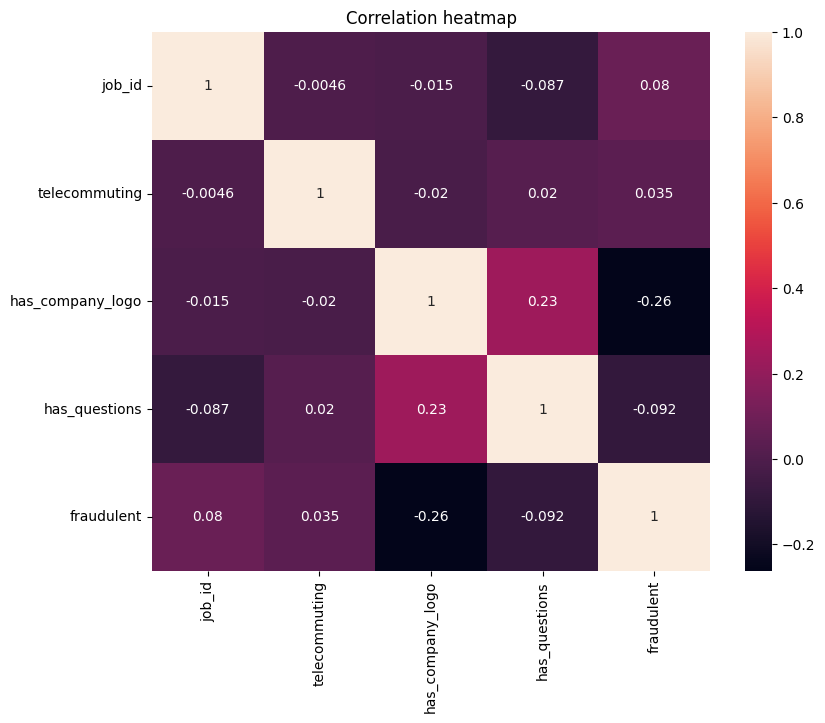

In [ ]:
fig = plt.figure(figsize=(9,7))
correlation_matrix = df1._get_numeric_data().corr()
sns.heatmap(correlation_matrix, annot=True)
ax = plt.title("Correlation heatmap")

95.1565995525727% of samples are real


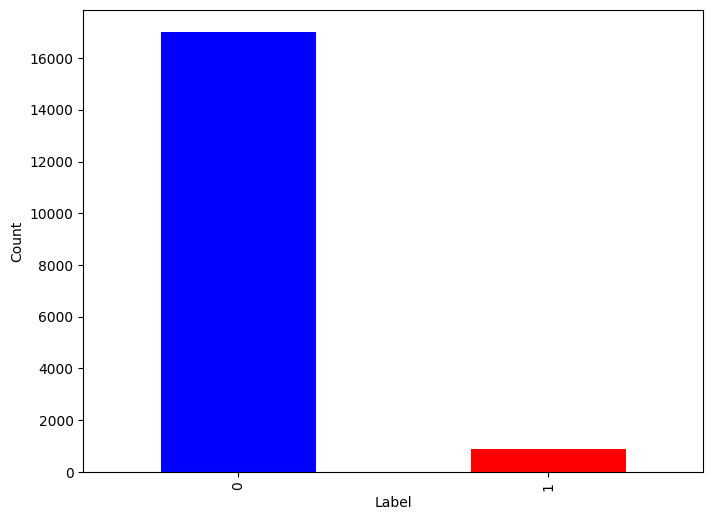

In [ ]:
plt.figure()
vc = df1["fraudulent"].value_counts()
vc.plot.bar(color=['b', 'r'], figsize=(8, 6))
plt.xlabel("Label")
plt.ylabel("Count")
percentage = (vc[0]/(vc[1]+vc[0]))*100
print(f'{percentage}% of samples are real')

**Number of samples per country**

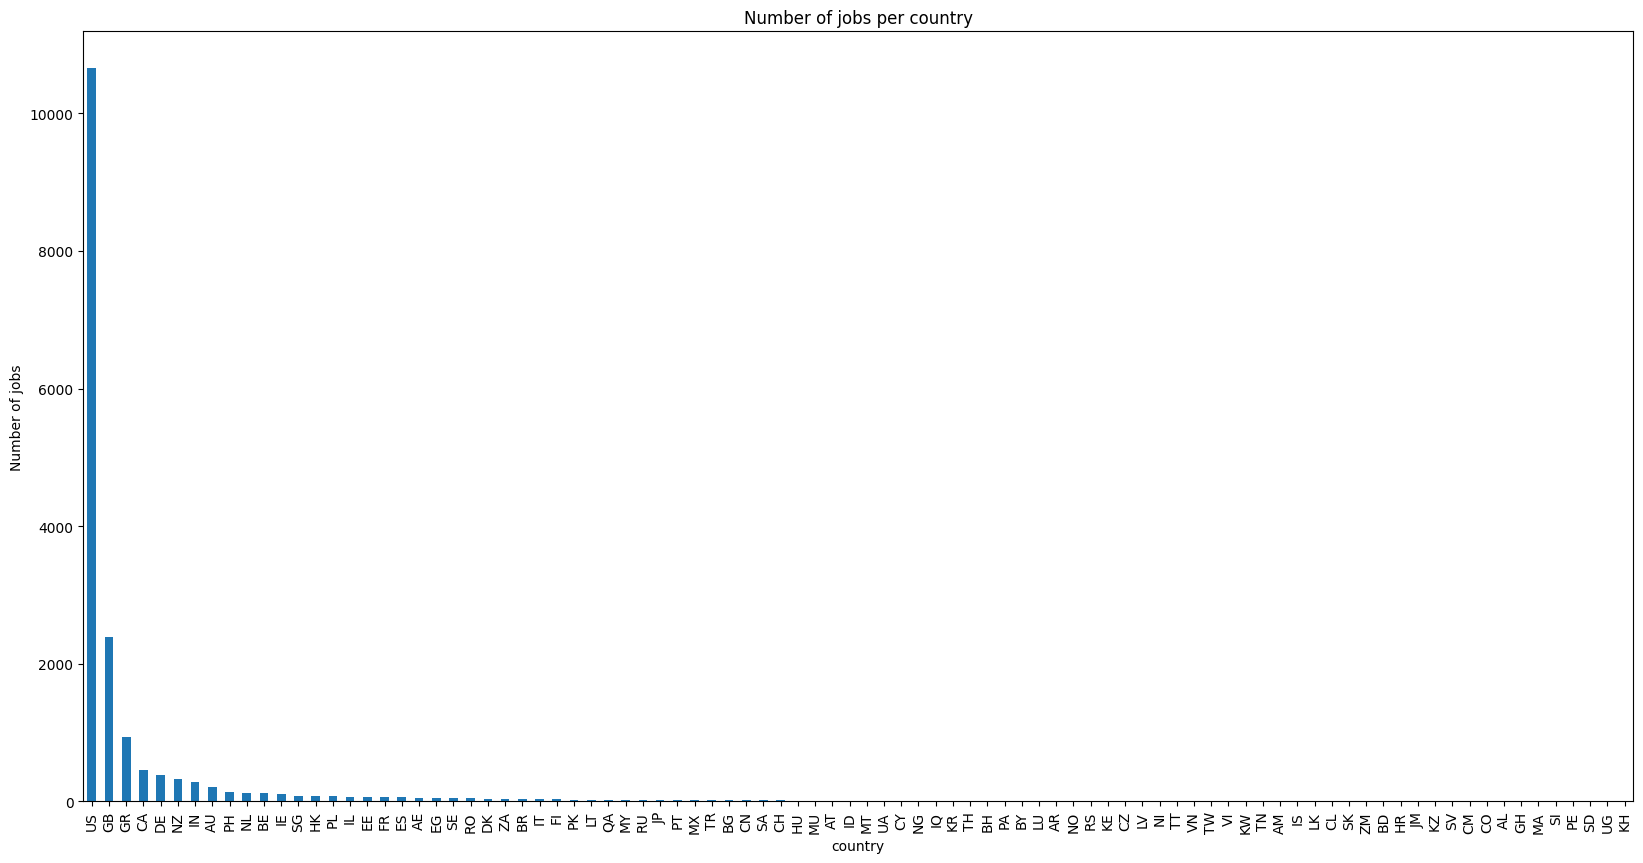

In [ ]:
plt.figure(figsize=(20, 10))
df1['location'].str.split(pat=', ', n=1, expand=True)[0].value_counts().plot.bar()
plt.xlabel("country")
plt.ylabel("Number of jobs")
ax = plt.title("Number of jobs per country")

From the above graph we can say that high number of samples are from United States and are in English Language.



**Filtering jobs from united states only to get more insights from the data**

In [ ]:
df1 = df1[df1['location'].str.split(pat=', ', n=1, expand=True)[0] == "US"]
df1.head(3)

,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0


After that we split the location into country,state and city.

In [ ]:
loc = df1['location'].str.split(pat=', ', n=2, expand=True)

df1.insert(2, "country", loc[0])
df1.insert(3, "state", loc[1])
df1.insert(4, "city", loc[2])

df1 = df1.drop(['location'], axis=1)
df1.head(3)

,job_id,title,country,state,city,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,US,NY,New York,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,3,Commissioning Machinery Assistant (CMA),US,IA,Wever,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,US,DC,Washington,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0


Dropped the rows where state and city is empty or Nan.

In [ ]:
df1 = df1[df1["state"] != ""]
df1 = df1[df1['state'].notna()]
df1 = df1[df1["city"] != ""]
df1 = df1[df1['city'].notna()]

**Number of samples per state of United States**

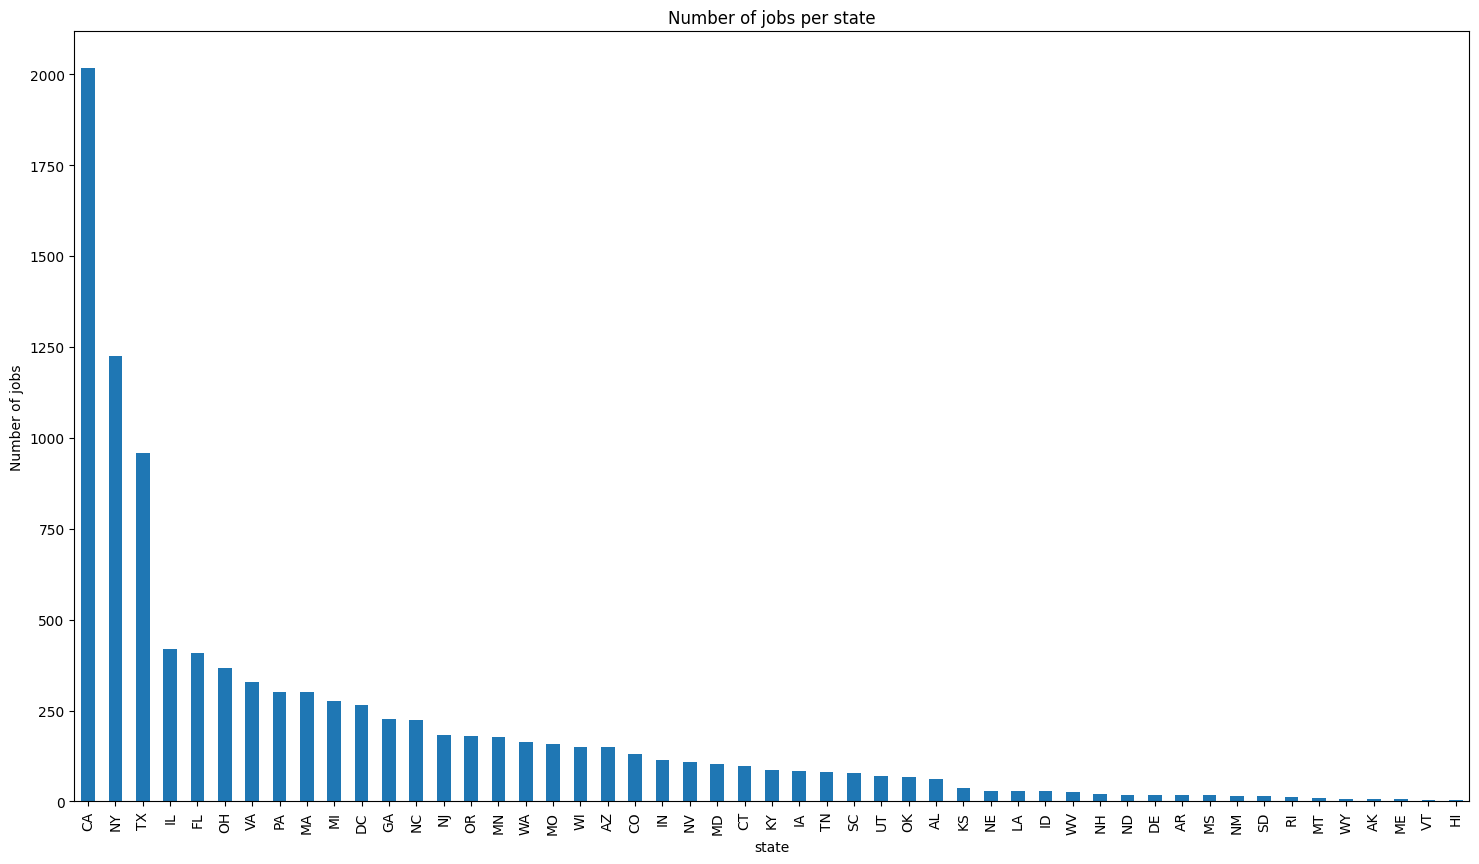

In [ ]:
plt.figure(figsize=(18, 10))
df1['state'].str.split(pat=', ', n=1, expand=True)[0].value_counts().plot.bar()
plt.xlabel("state")
plt.ylabel("Number of jobs")
ax = plt.title("Number of jobs per state")

**A comparison of the number of fraudulent vs real jobs in each state of United States**

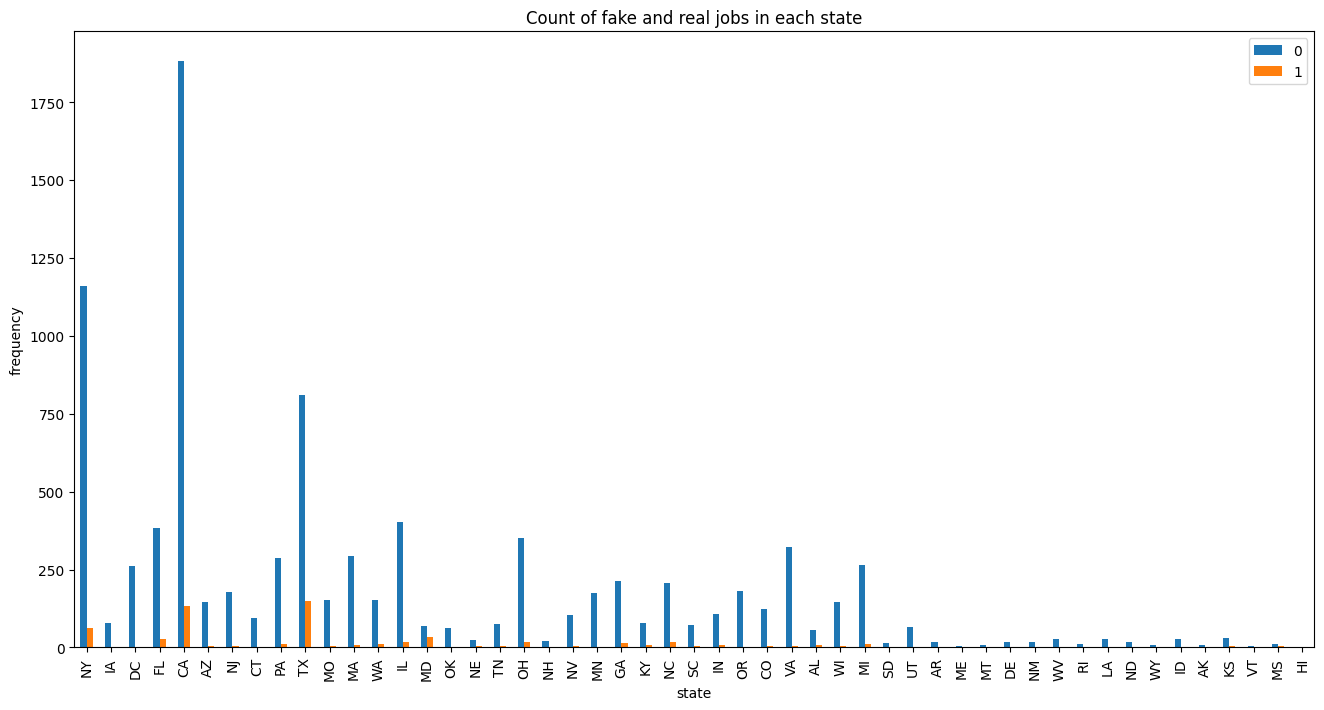

In [ ]:
data_freq = []
for state in df1["state"].unique():
    filter_state = df1[df1["state"] == state]
    data_freq.append([len(filter_state[filter_state["fraudulent"] == 0]), len(filter_state[filter_state["fraudulent"] == 1])])

df1_grouped = pd.DataFrame(data_freq, index=df1["state"].unique())
df1_grouped.plot.bar(figsize=(16, 8))
plt.xlabel("state")
plt.ylabel("frequency")
ax = plt.title("Count of fake and real jobs in each state")

Ratio of fake to real jobs based for each state, city.

Example: ratio for NY, Manhattan = fake jobs in NY, Manhattan / real jobs in NY, Manhattan

Only cities with ratio > 1 are displayed on the bar chart to avoid clutter.

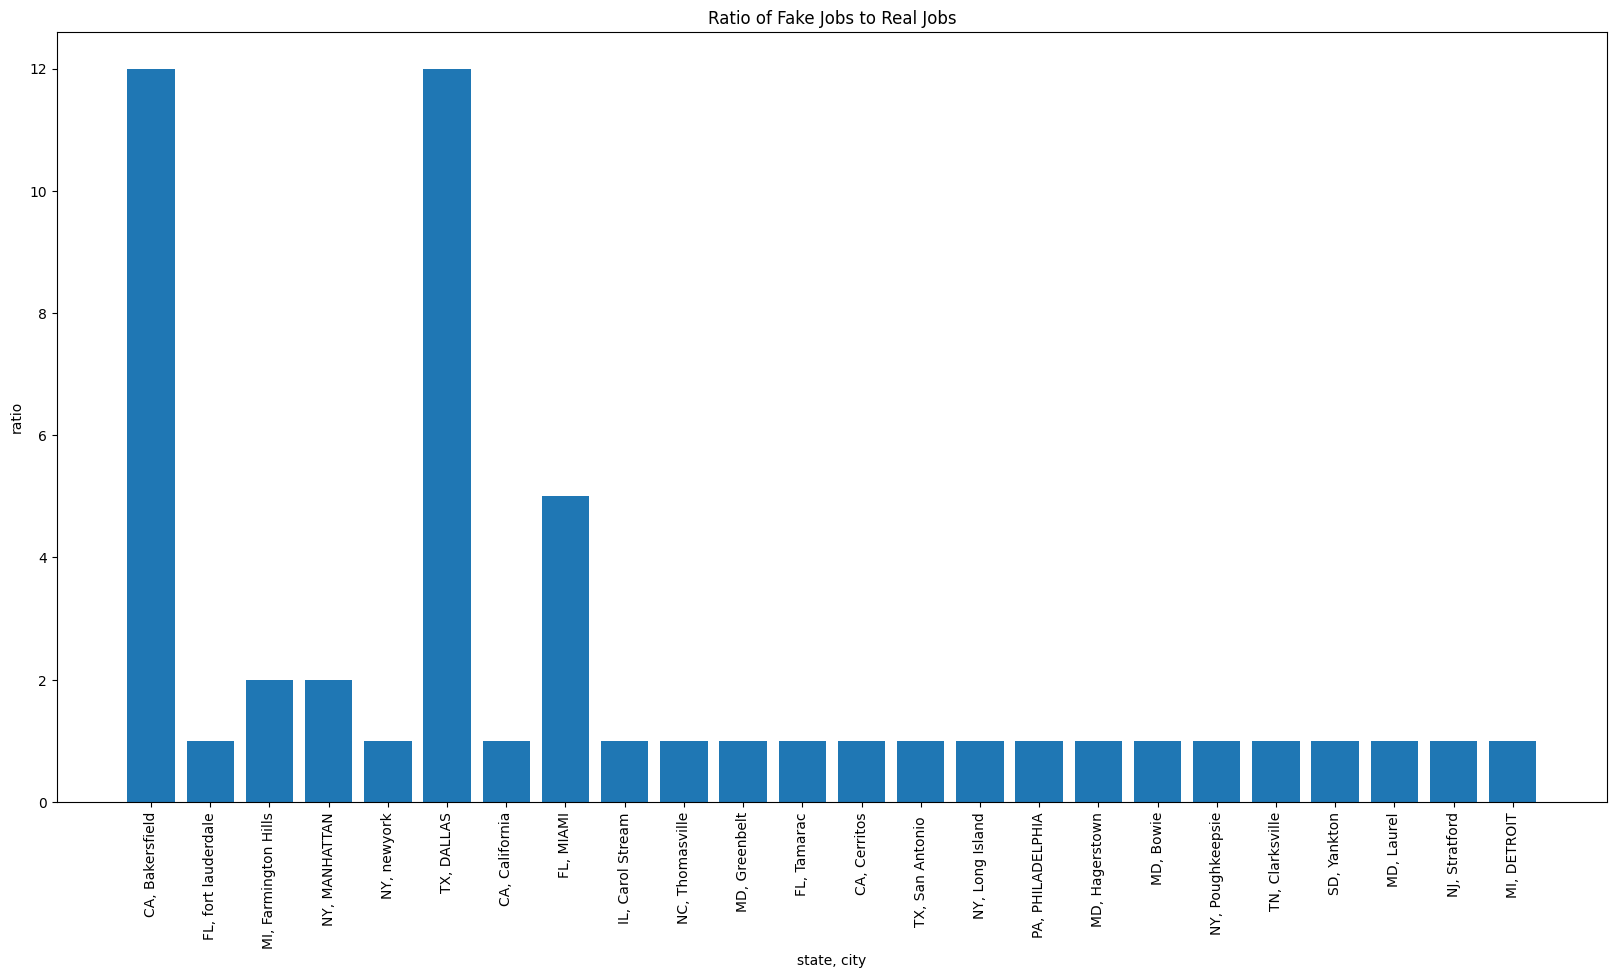

In [ ]:
labels = df1["state"] + ", " + df1["city"]
labels = labels.unique()
final_labels = []
ratio_data = []
for label in labels:
    state = label.split(", ")[0]
    city = label.split(", ")[1]
    if state + ", " + city not in final_labels:
        filter_state = df1[df1["state"] == state]
        filter_both = filter_state[filter_state["city"] == city]
        ratio = len(filter_both[filter_both["fraudulent"] == 1])
        if len(filter_both[filter_both["fraudulent"] == 0]) != 0:
            ratio /= len(filter_both[filter_both["fraudulent"] == 0])
            if ratio >= 1:
                ratio_data.append(ratio)
                final_labels.append(state + ", " + city)

plt.figure(figsize=(20, 10))
plt.bar(final_labels, ratio_data)
plt.ylabel("ratio")
plt.xlabel("state, city")
plt.title("Ratio of Fake Jobs to Real Jobs")
ax = plt.xticks(rotation=90)

**Investigating the counts of real and fake jobs for different categories in each column**

In [ ]:
def func(df, col):
    data_freq = []
    label = []
    for u in df1[col].unique():
        if u is not np.nan:
            filter_ = df1[df1[col] == u]
            data_freq.append([len(filter_[filter_["fraudulent"] == 0]), len(filter_[filter_["fraudulent"] == 1])])
            label.append(u)

    df1_grouped = pd.DataFrame(data_freq, index=label)
    df1_grouped.plot.bar(figsize=(12, 6))
    plt.title(f"Number fake and real jobs by {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

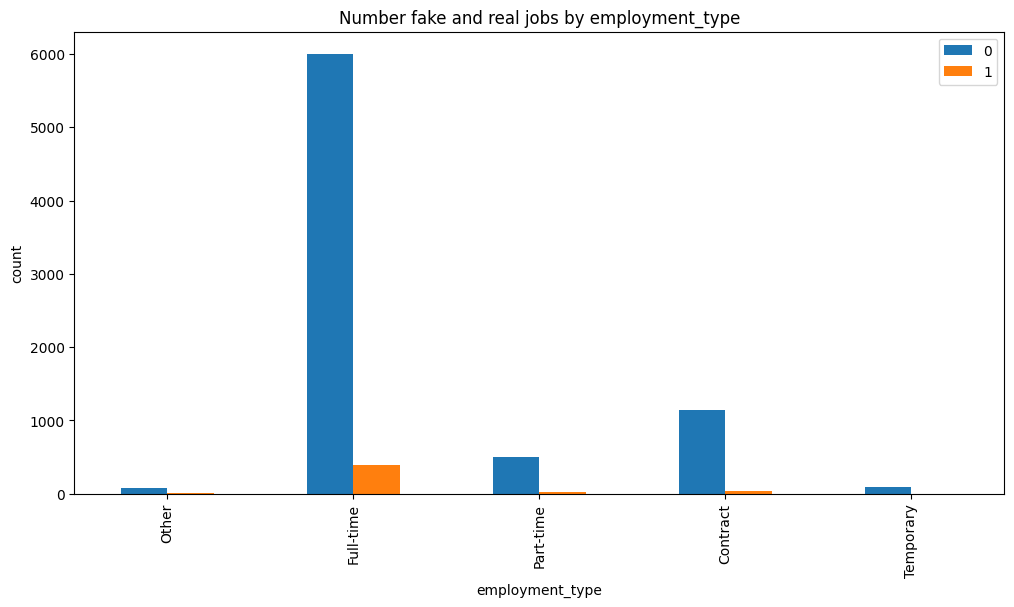

In [ ]:
func(df1, "employment_type")

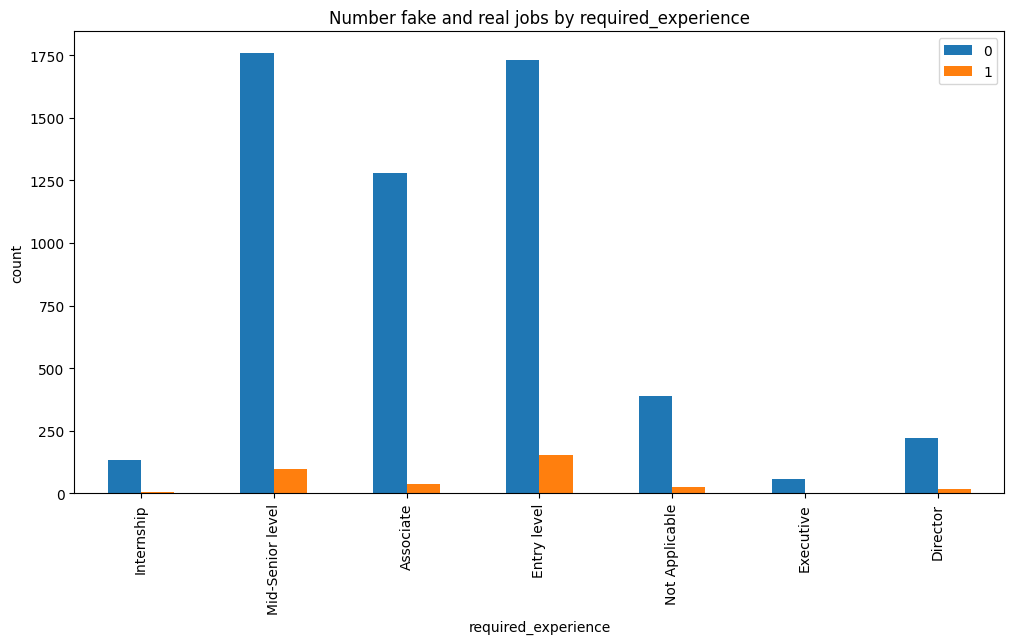

In [ ]:
func(df1, "required_experience")

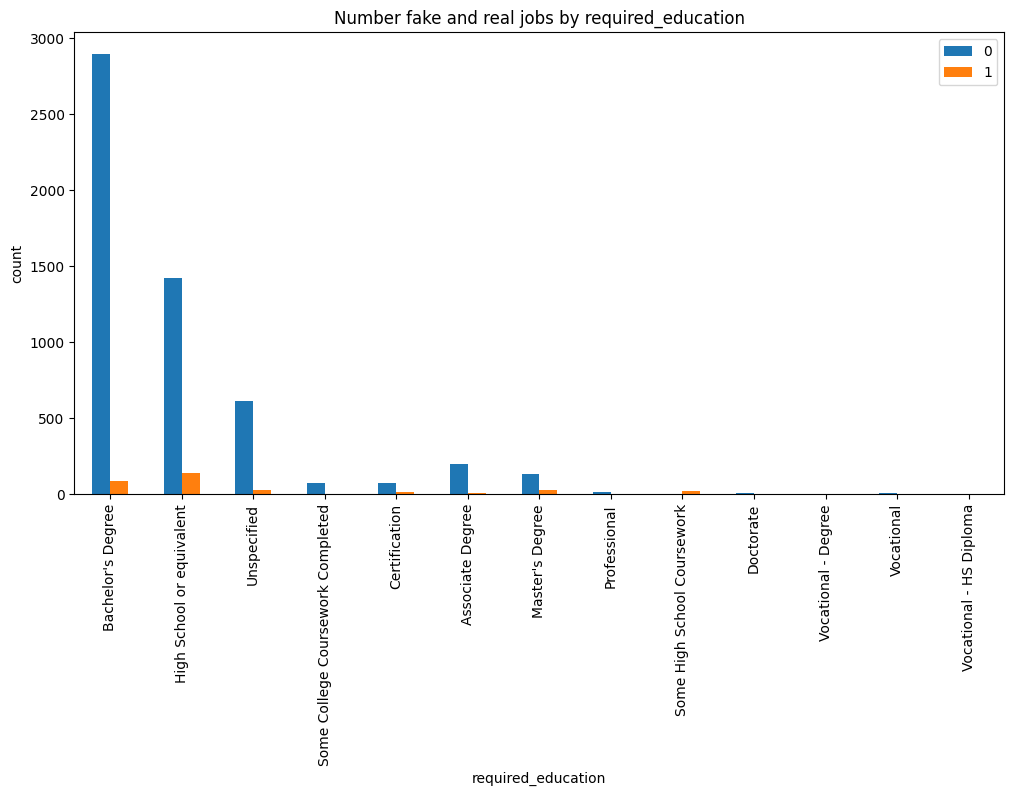

In [ ]:
func(df1, "required_education")

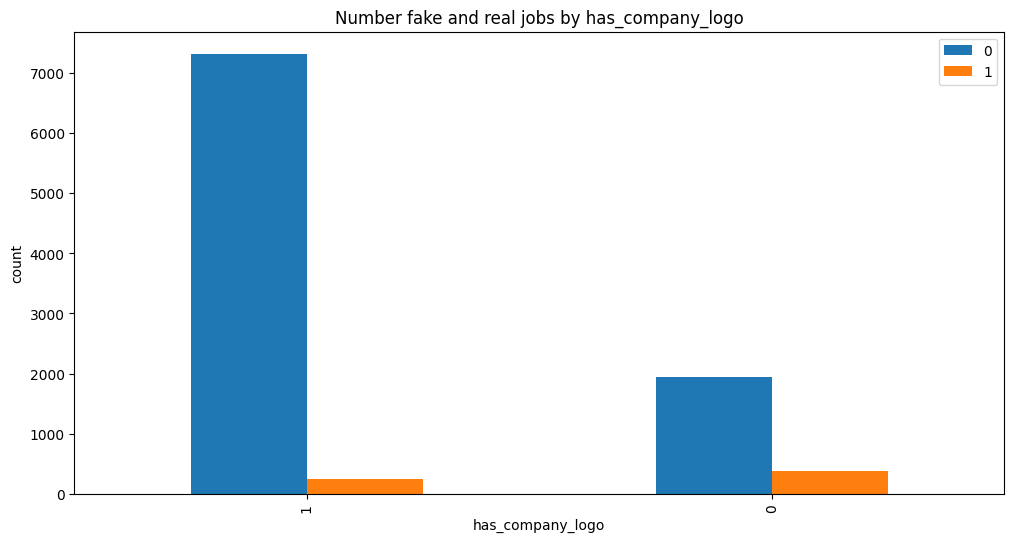

In [ ]:
func(df1, "has_company_logo")

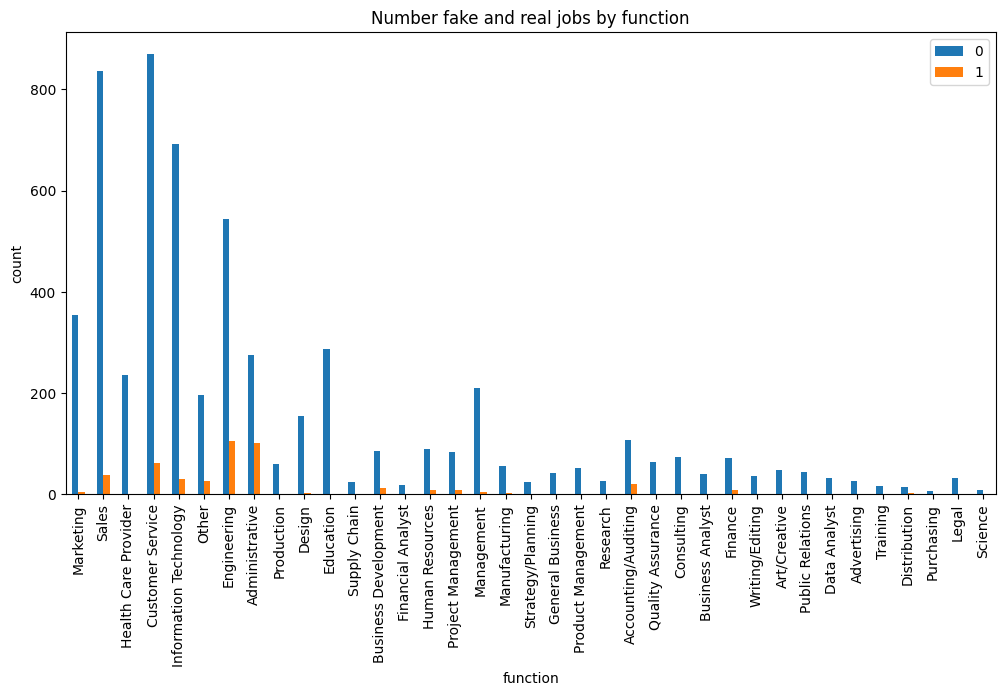

In [ ]:
func(df1, "function")

**Comparing the character count of real and fake jobs by plotting a histogram**

In order to compare the character count of real and fake jobs we first collate all the textual data e.g title, company_profile, and description into one single column.

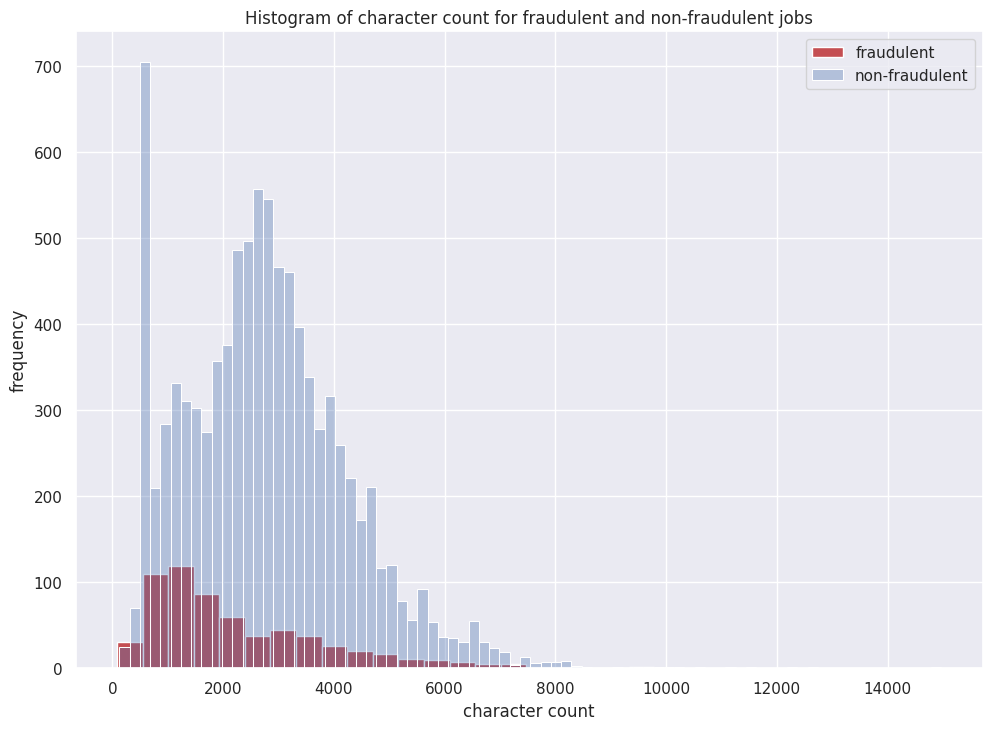

In [ ]:
df1 = df1.reset_index().drop(["index"], axis=1)
copy_df1 = df1.copy()
textual_columns = ["title", "company_profile", "description", "requirements", "benefits", "required_experience",
                  "required_education", "industry", "function"]
copy_df1["text"] = ""
for col in textual_columns:
    copy_df1[col] = copy_df1[col].fillna('')
    copy_df1["text"] =  copy_df1["text"] + " " + copy_df1[col]

fraud = copy_df1[copy_df1["fraudulent"] == 1]["text"].str.len()
non_fraud = copy_df1[copy_df1["fraudulent"] == 0]["text"].str.len()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(fraud, alpha=1, label="fraudulent", color='r')
sns.histplot(non_fraud, alpha=0.35, label="non-fraudulent", color='b')
plt.legend(["fraudulent", "non-fraudulent"])
plt.xlabel("character count")
plt.ylabel("frequency")
plt.title("Histogram of character count for fraudulent and non-fraudulent jobs")
plt.show()

From the above histogram we can see that real jobs generally have a much larger word count than fake jobs.

**Data Pre-processing**

In [ ]:
df=df1[['description','requirements','fraudulent']]
df=df.dropna()
X=df.drop('fraudulent',axis=1)
y=df['fraudulent']

In [ ]:
voc_size=5000
sent_length = 40

In [ ]:
message = X.copy()
message.reset_index(inplace=True)
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(message)):
    review = re.sub('[^a-zA-Z]', ' ', message['description'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

X['corpus'] = corpus


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X['corpus'] = corpus
X.reset_index(inplace=True)

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus]
print(len(onehot_repr[0]))
print(len(corpus[0].split(' ')))


84
84


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X['corpus'], np.array(y), test_size=0.2)

In [ ]:
# tokenization
tokenizer=Tokenizer()
tokenizer.fit_on_texts(corpus)
vocab=tokenizer.word_index
# Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.
x_train_word_ids=tokenizer.texts_to_sequences(X_train)
x_test_word_ids = tokenizer.texts_to_sequences(X_test)
# pad_sequences

x_train_padded_seqs=pad_sequences(x_train_word_ids,maxlen=sent_length)
x_test_padded_seqs=pad_sequences(x_test_word_ids, maxlen=sent_length)


In [ ]:
len(vocab)

25016

**LSTM Model**

In [ ]:
embedding_vector_features=300
model1=Sequential()
model1.add(Embedding(len(vocab)+1,embedding_vector_features,input_length=sent_length))
# model1.add(Bidirectional(LSTM(100))) ##Just add bidirectional!!, except it would just behave as normal LSTM Model
model1.add(LSTM(100))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 300)           7505100   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 7665601 (29.24 MB)
Trainable params: 7665601 (29.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
lstm_history = model1.fit(x_train_padded_seqs,y_train,validation_data=(x_test_padded_seqs,y_test),epochs=12,batch_size=800)

Epoch 1/12
9/9 [==============================] - 12s 1s/step - loss: 0.5938 - accuracy: 0.8861 - val_loss: 0.2820 - val_accuracy: 0.9300
Epoch 2/12
9/9 [==============================] - 8s 848ms/step - loss: 0.2664 - accuracy: 0.9353 - val_loss: 0.2438 - val_accuracy: 0.9300
Epoch 3/12
9/9 [==============================] - 10s 1s/step - loss: 0.2170 - accuracy: 0.9363 - val_loss: 0.2296 - val_accuracy: 0.9324
Epoch 4/12
9/9 [==============================] - 9s 1s/step - loss: 0.1861 - accuracy: 0.9427 - val_loss: 0.2065 - val_accuracy: 0.9360
Epoch 5/12
9/9 [==============================] - 8s 839ms/step - loss: 0.1526 - accuracy: 0.9513 - val_loss: 0.1818 - val_accuracy: 0.9469
Epoch 6/12
9/9 [==============================] - 9s 1s/step - loss: 0.1160 - accuracy: 0.9603 - val_loss: 0.1658 - val_accuracy: 0.9469
Epoch 7/12
9/9 [==============================] - 8s 860ms/step - loss: 0.0806 - accuracy: 0.9737 - val_loss: 0.1623 - val_accuracy: 0.9517
Epoch 8/12
9/9 [==============

In [ ]:
y_pred=model1.predict(x_test_padded_seqs)
y_pred = np.where(y_pred<0.5,0,1)

52/52 [==============================] - 2s 23ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[1522,   19],
       [  49,   67]])

In [ ]:
from sklearn.metrics import accuracy_score
lstm_accuracy = accuracy_score(y_test,y_pred)
print(lstm_accuracy)

0.9589619794809897


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1541
           1       0.78      0.58      0.66       116

    accuracy                           0.96      1657
   macro avg       0.87      0.78      0.82      1657
weighted avg       0.96      0.96      0.96      1657



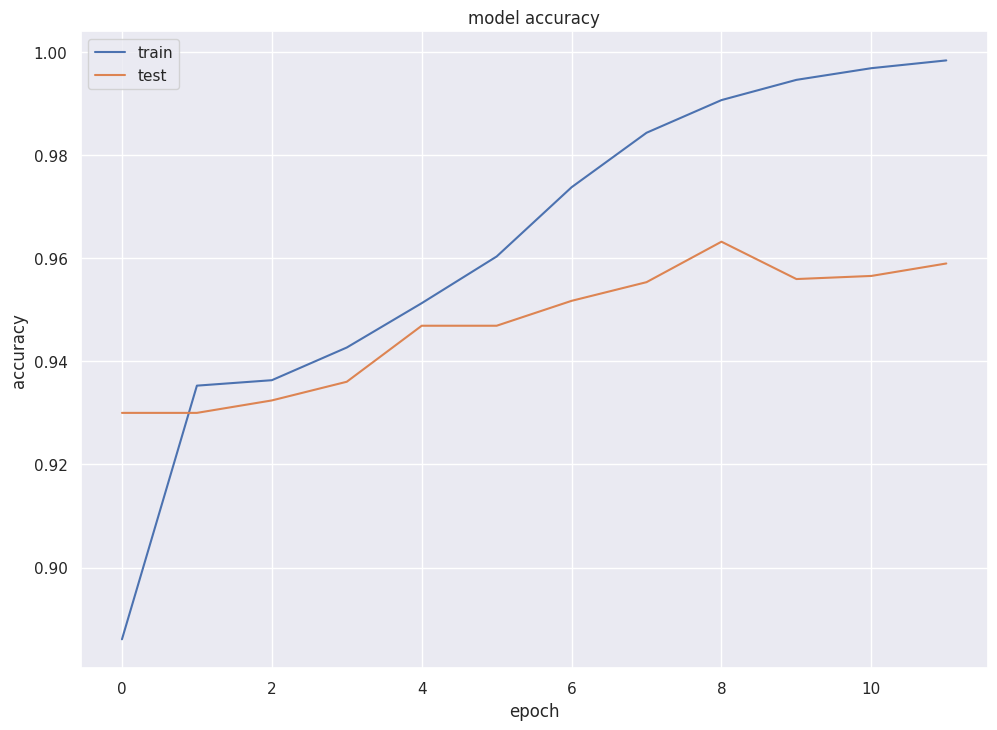

In [ ]:
# summarize history for accuracy
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

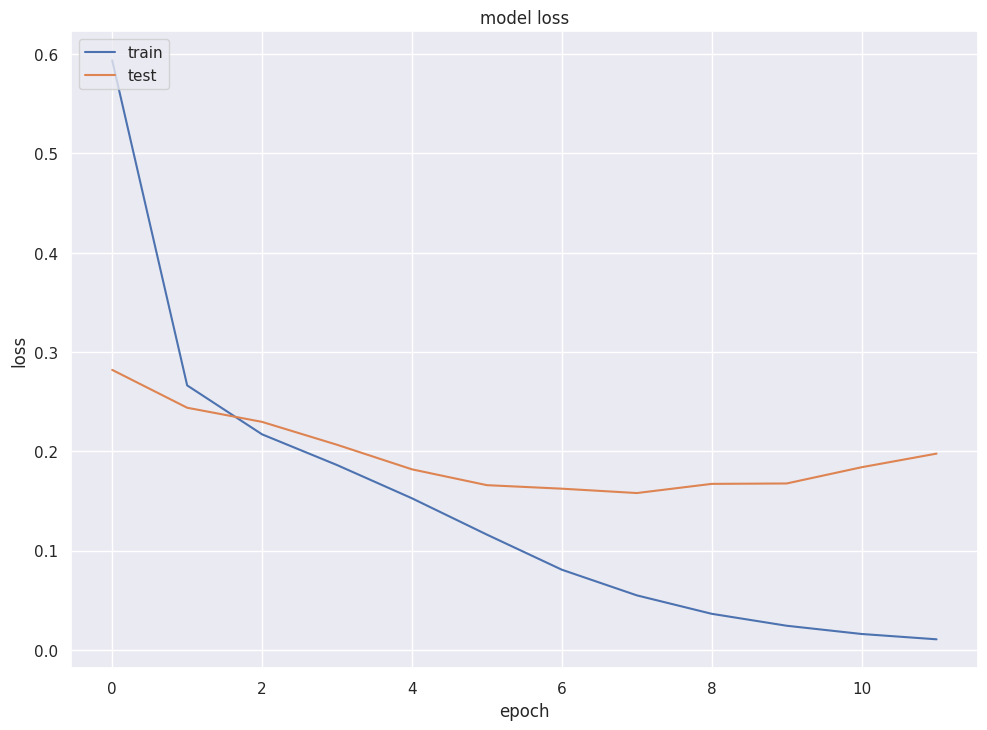

In [ ]:
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**CNN Model**

In [ ]:
embedding_vector_features=300
main_input = Input(shape=(sent_length,), dtype='int32')

embedder = Embedding(len(vocab)+1,embedding_vector_features,input_length=sent_length)
embed = embedder(main_input)
# LSTM
lstm = LSTM(100)(embed)
lstm = Dropout(0.3)(lstm)
# CNN
cnn = Conv1D(256, 5, padding='same')(embed)
cnn = MaxPooling1D(3, 3, padding='same')(cnn)
cnn = Conv1D(128, 5, padding='same')(cnn)
cnn = MaxPooling1D(3, 3, padding='same')(cnn)
cnn = Conv1D(64, 3, padding='same')(cnn)
cnn = Flatten()(cnn)
cnn = Dropout(0.1)(cnn)
cnn = BatchNormalization()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dropout(0.1)(cnn)
# AVG POOLING
# avg_pooling = Dense(100, activation='relu')(cnn) # not good

lstmncnn = concatenate([lstm, cnn], axis=-1)
flat = Flatten()(lstmncnn)
drop = Dropout(0.2)(flat)
main_output = Dense(1, activation='sigmoid')(drop)
model2 = Model(inputs=main_input, outputs=main_output)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 40, 300)              7505100   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 40, 256)              384256    ['embedding_1[0][0]']         
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 14, 256)              0         ['conv1d[0][0]']              
 D)                                                                                           

In [ ]:
cnn_history = model1.fit(x_train_padded_seqs,y_train,validation_data=(x_test_padded_seqs,y_test),epochs=12,batch_size=800)

Epoch 1/12
9/9 [==============================] - 11s 1s/step - loss: 0.0066 - accuracy: 0.9985 - val_loss: 0.2024 - val_accuracy: 0.9517
Epoch 2/12
9/9 [==============================] - 14s 2s/step - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.2152 - val_accuracy: 0.9584
Epoch 3/12
9/9 [==============================] - 7s 825ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.2314 - val_accuracy: 0.9553
Epoch 4/12
9/9 [==============================] - 9s 998ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.2507 - val_accuracy: 0.9529
Epoch 5/12
9/9 [==============================] - 8s 893ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.2577 - val_accuracy: 0.9547
Epoch 6/12
9/9 [==============================] - 8s 864ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.2682 - val_accuracy: 0.9529
Epoch 7/12
9/9 [==============================] - 9s 1s/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.2691 - val_accuracy: 0.9505
Epoch 8/12
9/9 [===========

In [ ]:
y_pred = model1.predict(x_test_padded_seqs)
y_pred = np.where(y_pred<0.5,0,1)

52/52 [==============================] - 1s 23ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[1513,   28],
       [  47,   69]])

In [ ]:
from sklearn.metrics import accuracy_score
cnn_accuracy = accuracy_score(y_test,y_pred)
print(cnn_accuracy)

0.9547374773687387


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1541
           1       0.71      0.59      0.65       116

    accuracy                           0.95      1657
   macro avg       0.84      0.79      0.81      1657
weighted avg       0.95      0.95      0.95      1657



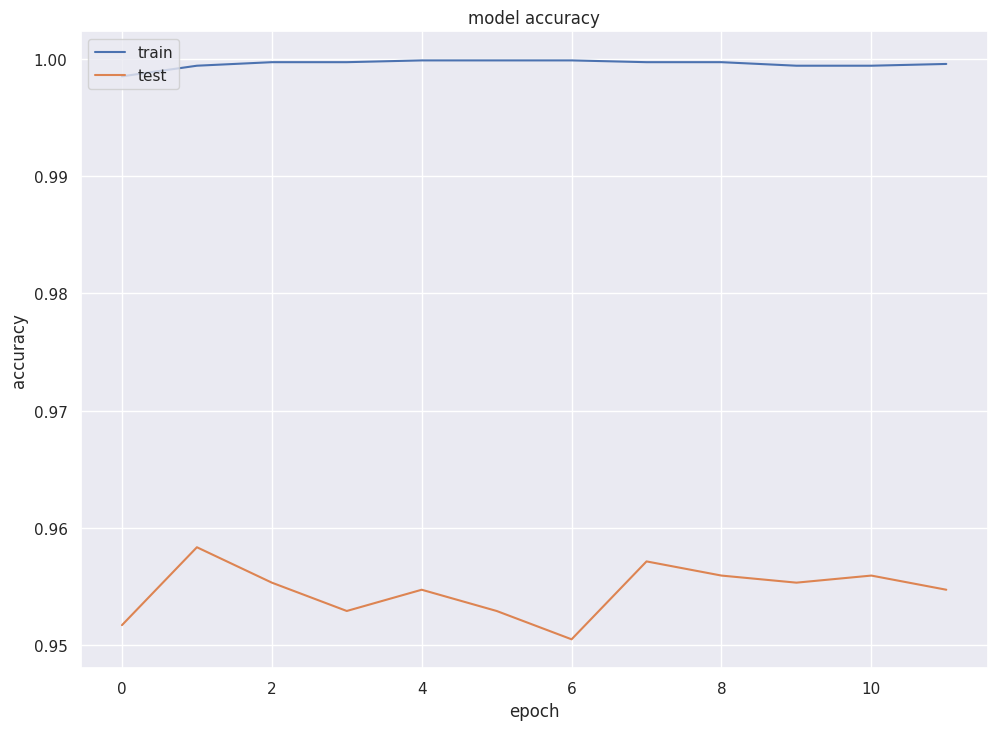

In [ ]:
# summarize history for accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

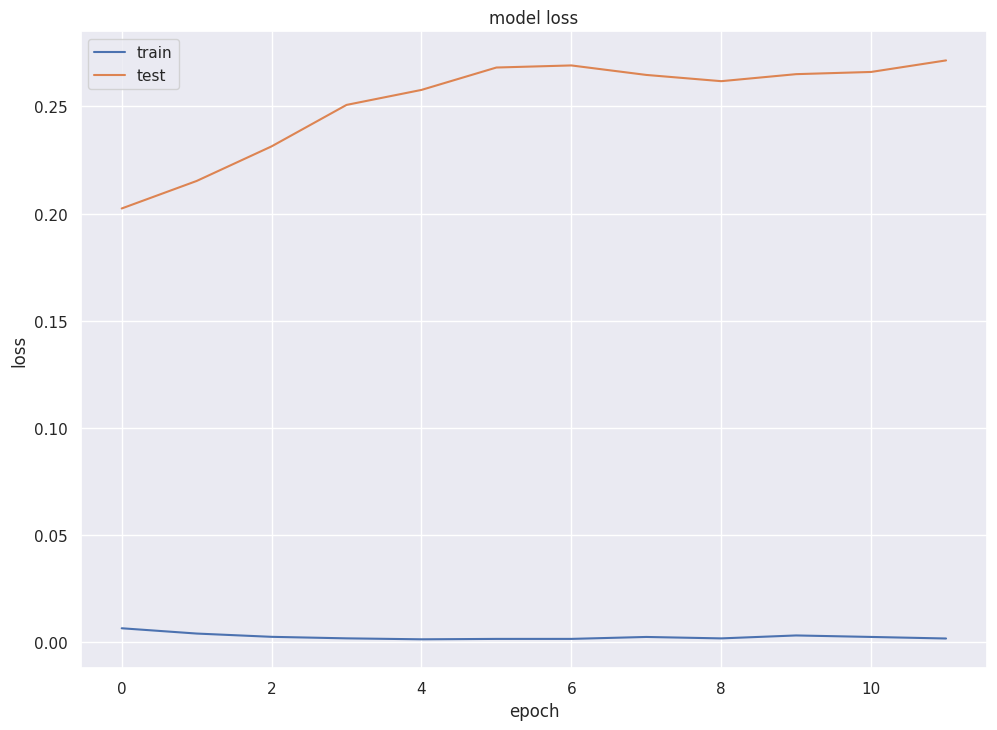

In [ ]:
# summarize history for loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Logistic Regression**

Test Accuracy: 0.9571514785757392
Confusion Matrix:
 [[1542    0]
 [  71   44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1542
           1       1.00      0.38      0.55       115

    accuracy                           0.96      1657
   macro avg       0.98      0.69      0.77      1657
weighted avg       0.96      0.96      0.95      1657



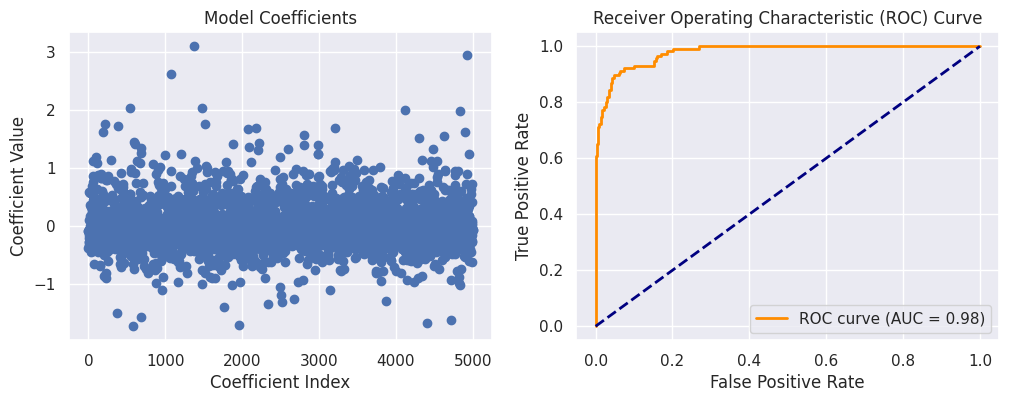

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(corpus, np.array(y), test_size=0.2, random_state=42)

# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=voc_size, ngram_range=(1, 3))
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()

# Perform cross-validated predictions on the training data
logistic_regression_cv_pred_train = cross_val_predict(logistic_regression_model, X_tfidf, y, cv=stratified_cv)

# Use the trained model to predict on the test set
logistic_regression_model.fit(X_tfidf, y)
logistic_regression_cv_pred_test = logistic_regression_model.predict(tfidf_vectorizer.transform(X_test))

# Print Accuracy, Confusion Matrix, and Classification Report on the test set
y_pred_test = logistic_regression_model.predict(tfidf_vectorizer.transform(X_test))

# Accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix_test)

# Classification Report
class_report_test = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_report_test)

# Plot model accuracy and loss
plt.figure(figsize=(12, 4))

# Plot Training & Validation Accuracy Values
plt.subplot(1, 2, 1)
plt.plot(logistic_regression_model.coef_.flatten(), 'o')
plt.title('Model Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')

# ROC Curve and AUC
# Predict probabilities for the positive class (class 1)
y_probs = logistic_regression_model.predict_proba(tfidf_vectorizer.transform(X_test))[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


**Support Vector Classifier**

Test Accuracy: 0.9571514785757392
Confusion Matrix:
 [[1542    0]
 [  47   68]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1542
           1       1.00      0.59      0.74       115

    accuracy                           0.97      1657
   macro avg       0.99      0.80      0.86      1657
weighted avg       0.97      0.97      0.97      1657



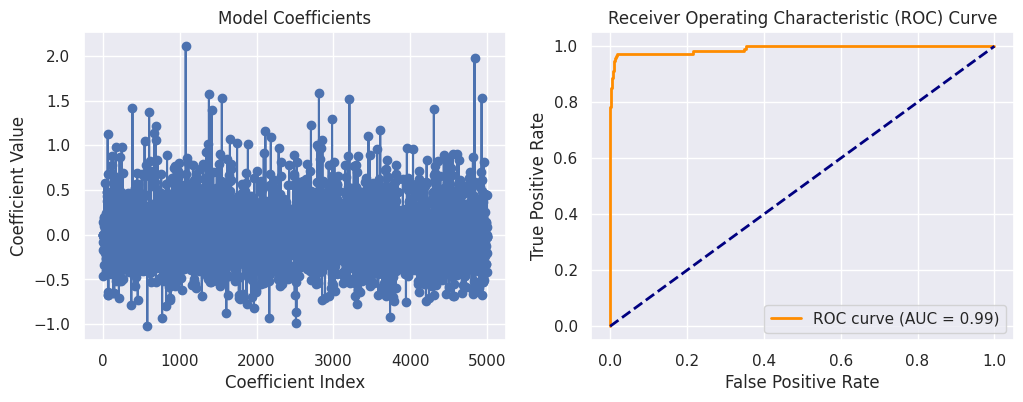

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.svm import SVC
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(corpus, np.array(y), test_size=0.2, random_state=42)

# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=voc_size, ngram_range=(1, 3))
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svc_model = SVC(kernel="linear")
svc_cv_pred_train = cross_val_predict(svc_model, X_tfidf, y, cv=stratified_cv)
svc_model.fit(X_tfidf, y)
svc_cv_pred_test = svc_model.predict(tfidf_vectorizer.transform(X_test))
y_pred_test = svc_model.predict(tfidf_vectorizer.transform(X_test))

# Accuracy
svc_accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix_test)

# Classification Report
class_report_test = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_report_test)

plt.figure(figsize=(12, 4))

# Plot Model Coefficients
plt.subplot(1, 2, 1)
coef_values = svc_model.coef_.toarray().flatten()  # Convert to a dense array and flatten
coef_indices = np.arange(coef_values.shape[0])
plt.plot(coef_indices, coef_values, 'o-')
plt.title('Model Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')

# ROC Curve and AUC
# Predict probabilities for the positive class (class 1)
y_probs = svc_model.decision_function(tfidf_vectorizer.transform(X_test))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

**Random Forest**

Test Accuracy: 0.9571514785757392
Confusion Matrix:
 [[1542    0]
 [  82   33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1542
           1       1.00      0.29      0.45       115

    accuracy                           0.95      1657
   macro avg       0.97      0.64      0.71      1657
weighted avg       0.95      0.95      0.94      1657



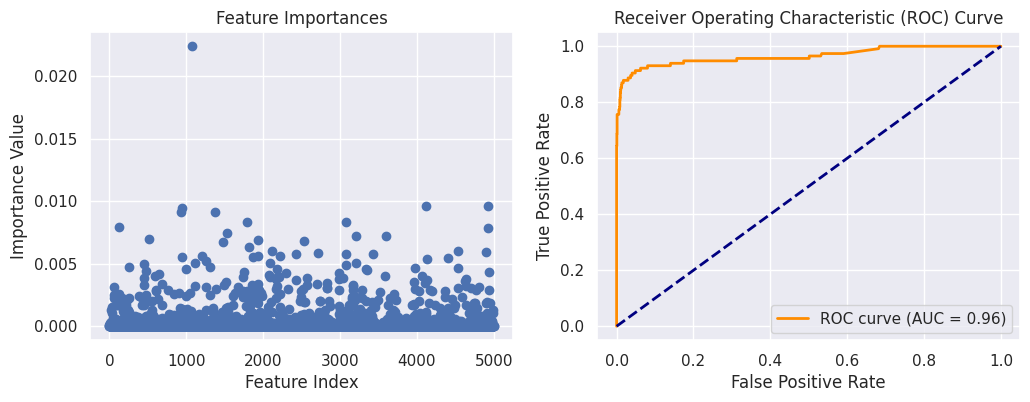

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(corpus, np.array(y), test_size=0.2, random_state=42)

# Vectorization using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=voc_size, ngram_range=(1, 3))
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# Define cross-validation strategy
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest Classifier
random_forest_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Perform cross-validated predictions on the training data
random_forest_cv_pred_train = cross_val_predict(random_forest_model, X_tfidf, y, cv=stratified_cv)

# Use the trained model to predict on the test set
random_forest_model.fit(X_tfidf, y)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
random_forest_cv_pred_test = random_forest_model.predict(X_test_tfidf)

# Print Accuracy, Confusion Matrix, and Classification Report on the test set
y_pred_test = random_forest_model.predict(X_test_tfidf)

# Accuracy
random_forest_accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", conf_matrix_test)

# Classification Report
class_report_test = classification_report(y_test, y_pred_test)
print("Classification Report:\n", class_report_test)

plt.figure(figsize=(12, 4))

# Plot Feature Importances
plt.subplot(1, 2, 1)
plt.plot(random_forest_model.feature_importances_, 'o')
plt.title('Feature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance Value')

# ROC Curve and AUC
# Predict probabilities for the positive class (class 1)
y_probs = random_forest_model.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


**Stochastic Gradient Descent**

Test Accuracy (SGD): 0.9740494870247435
Confusion Matrix (SGD):
 [[1542    0]
 [  43   72]]
Classification Report (SGD):
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1542
           1       1.00      0.63      0.77       115

    accuracy                           0.97      1657
   macro avg       0.99      0.81      0.88      1657
weighted avg       0.97      0.97      0.97      1657



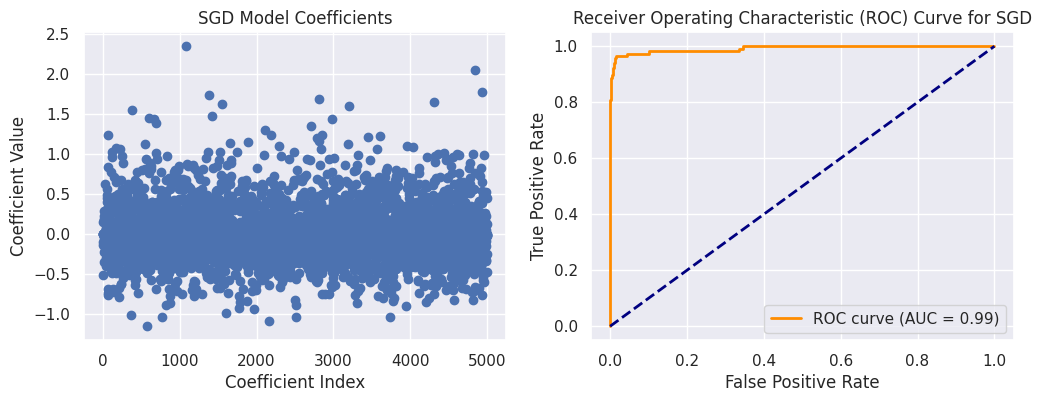

In [ ]:
from sklearn.linear_model import SGDClassifier

# Stochastic Gradient Descent (SGD) Classifier
sgd_model = SGDClassifier()

# Perform cross-validated predictions on the training data
sgd_cv_pred_train = cross_val_predict(sgd_model, X_tfidf, y, cv=stratified_cv)

# Use the trained model to predict on the test set
sgd_model.fit(X_tfidf, y)
sgd_cv_pred_test = sgd_model.predict(tfidf_vectorizer.transform(X_test))

# Print Accuracy, Confusion Matrix, and Classification Report on the test set
y_pred_test_sgd = sgd_model.predict(tfidf_vectorizer.transform(X_test))

# Accuracy
accuracy_test_sgd = accuracy_score(y_test, y_pred_test_sgd)
print("Test Accuracy (SGD):", accuracy_test_sgd)

# Confusion Matrix
conf_matrix_test_sgd = confusion_matrix(y_test, y_pred_test_sgd)
print("Confusion Matrix (SGD):\n", conf_matrix_test_sgd)

# Classification Report
class_report_test_sgd = classification_report(y_test, y_pred_test_sgd)
print("Classification Report (SGD):\n", class_report_test_sgd)

# Plot model accuracy and loss for SGD
plt.figure(figsize=(12, 4))

# Plot Training & Validation Accuracy Values for SGD
plt.subplot(1, 2, 1)
plt.plot(sgd_model.coef_.flatten(), 'o')
plt.title('SGD Model Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')

# ROC Curve and AUC for SGD
# Predict probabilities for the positive class (class 1)
y_probs_sgd = sgd_model.decision_function(tfidf_vectorizer.transform(X_test))

# Compute ROC curve and AUC for SGD
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test, y_probs_sgd)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

# Plot ROC Curve for SGD
plt.subplot(1, 2, 2)
plt.plot(fpr_sgd, tpr_sgd, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_sgd))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SGD')
plt.legend(loc='lower right')

plt.show()


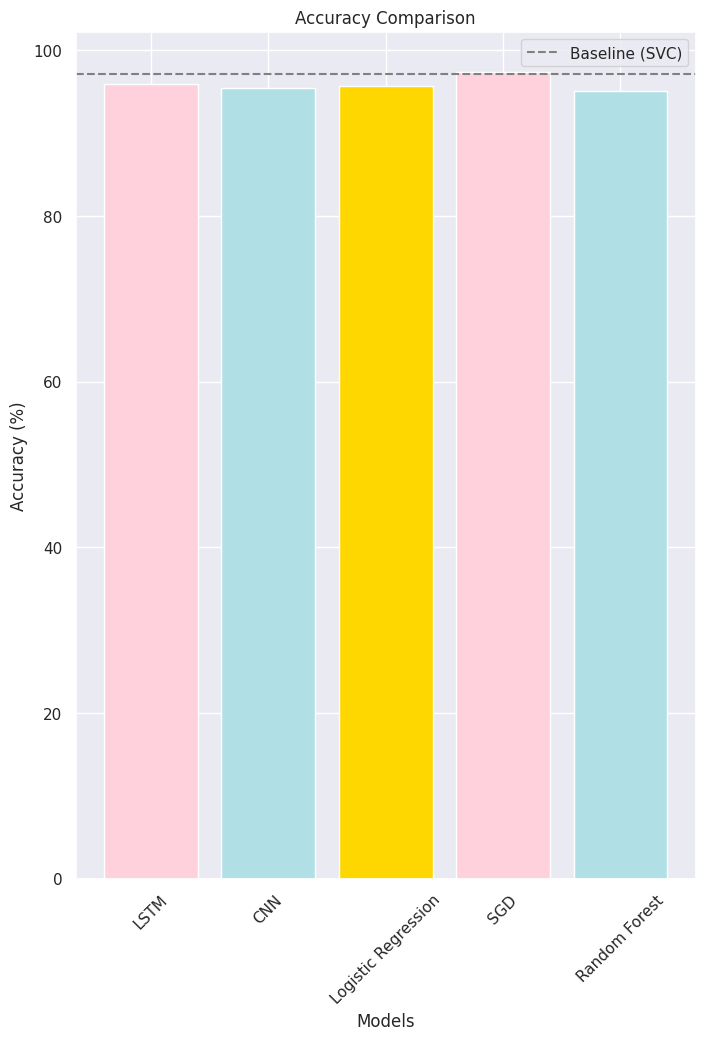

In [ ]:
# Model names
models = ['LSTM', 'CNN', 'Logistic Regression','SGD','Random Forest']

# Accuracy values
accuracies = [lstm_accuracy*100, cnn_accuracy*100, accuracy_test*100, accuracy_test_sgd*100, random_forest_accuracy_test*100]

# Baseline accuracy
baseline_accuracy = svc_accuracy_test*100  #

# Define a pastel color palette
colors = ['#FFD1DC', '#B0E0E6', '#FFD700', '#FFD1DC', '#B0E0E6']

# Create bar plot for Accuracy with pastel colors
plt.figure(figsize=(8, 11))
plt.bar(models, accuracies, color=colors)
plt.axhline(y=baseline_accuracy, color='gray', linestyle='--', label='Baseline (SVC)')
plt.title('Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.xticks(rotation=45)
plt.show()